### RNN이 NLP 모형에 미치는 영향

- [dataset for NLP](https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp)
- RNN 쓰고 쓰지 않고 모델 비교

In [391]:
import numpy as np
import pandas as pd

#### 데이터 확인

In [392]:
train = pd.read_table("./0. data/train.txt", sep=';', names=["text", "emote"])
val = pd.read_table("./0. data/val.txt", sep=';', names=["text", "emote"])
test = pd.read_table("./0. data/test.txt", sep=';', names=["text", "emote"])

In [393]:
print(train.shape, val.shape, test.shape)
print(train.iloc[0, :])

(16000, 2) (2000, 2) (2000, 2)
text     i didnt feel humiliated
emote                    sadness
Name: 0, dtype: object


In [394]:
text = train.iloc[:, 0]; vtext = val.iloc[:, 0]; ttext = test.iloc[:, 0]
emote = train.iloc[:, 1]; vemote = val.iloc[:, 1]; temote = test.iloc[:, 1]

In [395]:
print(text[0], emote[0], sep="\n")

i didnt feel humiliated
sadness


#### 데이터 전처리

- sklearn LabelEncoder
<!-- from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit((pd.Series(text).append(vtext)).append(ttext))
text_s = encoder.transform(text)
text_v = encoder.transform(vtext)
text_t = encoder.transform(ttext) -->

In [396]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

In [397]:
ttoken = Tokenizer()
ttoken.fit_on_texts((pd.Series(text).append(vtext)).append(ttext))
text_s = ttoken.texts_to_sequences(text)
text_v = ttoken.texts_to_sequences(vtext)
text_t = ttoken.texts_to_sequences(ttext)

In [398]:
max_value = np.max(text_s[0])
for i in range(len(text_s)):
    max_value = np.max([np.max(text_s[i]), max_value])
for i in range(len(text_v)):
    max_value = np.max([np.max(text_v[i]), max_value])
for i in range(len(text_t)):
    max_value = np.max([np.max(text_t[i]), max_value])
print(max_value)

17096


In [399]:
text_s = pad_sequences(text_s, maxlen=100)
text_v = pad_sequences(text_v, maxlen=100)
text_t = pad_sequences(text_t, maxlen=100)

In [400]:
etoken = Tokenizer()
etoken.fit_on_texts((pd.Series(emote).append(vemote)).append(temote))
emote_s = etoken.texts_to_sequences(emote)
emote_v = etoken.texts_to_sequences(vemote)
emote_t = etoken.texts_to_sequences(temote)

In [401]:
classes = np.max(emote_s)
classes = np.max(np.array(emote_v, classes))
classes = np.max(np.array(emote_t, classes))
print(classes)

6


In [402]:
emote_s = to_categorical(emote_s, num_classes=classes + 1)
emote_v = to_categorical(emote_v, num_classes=classes + 1)
emote_t = to_categorical(emote_t, num_classes=classes + 1)

#### 모형 학습

In [403]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from keras.layers import Embedding, LSTM
from keras.layers import Conv1D, MaxPool1D, Dense
from keras.layers import BatchNormalization, Dropout, Flatten

import tensorflow as tf
import matplotlib.pyplot as plt

In [404]:
early_stopping = EarlyStopping(monitor="val_loss", patience=15)

#### RNN을 이용하지 않았을 때

In [405]:
np.random.seed(3)
tf.random.set_seed(3)

In [406]:
model = Sequential()
model.add(Embedding(max_value + 1, 100, input_length=100))
model.add(Conv1D(64, kernel_size=3))
model.add(Conv1D(32, kernel_size=3, activation="relu"))
model.add(MaxPool1D(pool_size=4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(classes + 1, activation="softmax"))

In [407]:
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 100, 100)          1709700   
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 98, 64)            19264     
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 96, 32)            6176      
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 24, 32)            0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 768)               0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 768)               3072      
_________________________________________________________________
dense_70 (Dense)             (None, 64)              

In [408]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [409]:
history = model.fit(text_s, emote_s, validation_data=(text_v, emote_v), batch_size=100, epochs=50, callbacks=[early_stopping])

Train on 16000 samples, validate on 2000 samples
Epoch 1/50
16000/16000 [==============================] - 11s 678us/step - loss: 1.6013 - accuracy: 0.3724 - val_loss: 1.5583 - val_accuracy: 0.4780
Epoch 2/50
16000/16000 [==============================] - 14s 850us/step - loss: 0.7344 - accuracy: 0.7440 - val_loss: 0.7658 - val_accuracy: 0.7570
Epoch 3/50
16000/16000 [==============================] - 13s 816us/step - loss: 0.2937 - accuracy: 0.8969 - val_loss: 0.4019 - val_accuracy: 0.8730
Epoch 4/50
16000/16000 [==============================] - 13s 817us/step - loss: 0.1580 - accuracy: 0.9468 - val_loss: 0.3850 - val_accuracy: 0.8895
Epoch 5/50
16000/16000 [==============================] - 13s 821us/step - loss: 0.0955 - accuracy: 0.9697 - val_loss: 0.4570 - val_accuracy: 0.8905
Epoch 6/50
16000/16000 [==============================] - 13s 807us/step - loss: 0.0711 - accuracy: 0.9767 - val_loss: 0.4579 - val_accuracy: 0.8715
Epoch 7/50
16000/16000 [==============================] -

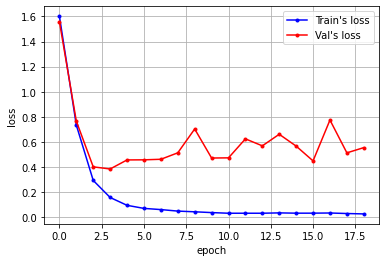

In [410]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

x_len = np.arange(len(loss))
plt.plot(x_len, loss, marker='.', c="blue", label="Train's loss")
plt.plot(x_len, val_loss, marker='.', c="red", label="Val's loss")

plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="upper right")
plt.show()

In [411]:
print("Trainset Accuracy: %.4f" % ((model.evaluate(text_s, emote_s)[1] + model.evaluate(text_v, emote_v)[1]) * 0.5))
print("Testset Accuracy: %.4f" % model.evaluate(text_t, emote_t)[1])

2000/2000 [==============================] - 0s 219us/step
Trainset Accuracy: 0.9356
2000/2000 [==============================] - 0s 187us/step
Testset Accuracy: 0.8750


#### RNN을 이용했을 때

In [412]:
np.random.seed(3)
tf.random.set_seed(3)

In [413]:
model = Sequential()
model.add(Embedding(max_value + 1, 100, input_length=100))
model.add(Conv1D(64, kernel_size=3))
model.add(Conv1D(32, kernel_size=3, activation="relu"))
model.add(MaxPool1D(pool_size=4))
model.add(LSTM(64))
model.add(BatchNormalization())
model.add(Dense(64, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(classes + 1, activation="softmax"))

In [414]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 100, 100)          1709700   
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 98, 64)            19264     
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 96, 32)            6176      
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 24, 32)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                24832     
_________________________________________________________________
batch_normalization_22 (Batc (None, 64)                256       
_________________________________________________________________
dense_73 (Dense)             (None, 64)              

In [415]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [416]:
history = model.fit(text_s, emote_s, validation_data=(text_v, emote_v), batch_size=100, epochs=50, callbacks=[early_stopping])

Train on 16000 samples, validate on 2000 samples
Epoch 1/50
16000/16000 [==============================] - 15s 935us/step - loss: 1.3914 - accuracy: 0.4750 - val_loss: 1.4662 - val_accuracy: 0.5990
Epoch 2/50
16000/16000 [==============================] - 15s 956us/step - loss: 0.3937 - accuracy: 0.8683 - val_loss: 0.9725 - val_accuracy: 0.5535
Epoch 3/50
16000/16000 [==============================] - 16s 1ms/step - loss: 0.1600 - accuracy: 0.9448 - val_loss: 1.3028 - val_accuracy: 0.6435
Epoch 4/50
16000/16000 [==============================] - 17s 1ms/step - loss: 0.0960 - accuracy: 0.9679 - val_loss: 1.5236 - val_accuracy: 0.6415
Epoch 5/50
16000/16000 [==============================] - 15s 918us/step - loss: 0.0592 - accuracy: 0.9801 - val_loss: 2.1412 - val_accuracy: 0.5360
Epoch 6/50
16000/16000 [==============================] - 14s 896us/step - loss: 0.0555 - accuracy: 0.9821 - val_loss: 1.5772 - val_accuracy: 0.6810
Epoch 7/50
16000/16000 [==============================] - 14s

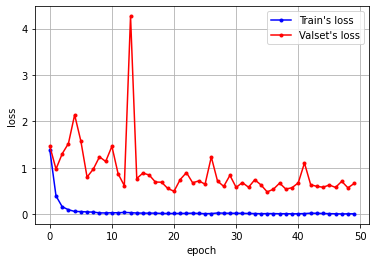

In [417]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
x_len = np.arange(len(loss))

plt.plot(x_len, loss, marker='.', c="blue", label="Train's loss")
plt.plot(x_len, val_loss, marker='.', c="red", label="Valset's loss")

plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="upper right")
plt.show()

In [418]:
print("Trainset Accuracy: %.4f" % ((model.evaluate(text_s, emote_s)[1] + model.evaluate(text_v, emote_v)[1]) * 0.5))
print("Testset Accuracy: %.4f" % model.evaluate(text_t, emote_t)[1])

2000/2000 [==============================] - 1s 331us/step
Trainset Accuracy: 0.9549
2000/2000 [==============================] - 1s 335us/step
Testset Accuracy: 0.9060


- 0.9455 (0.8935) (batch_size=100, 50, 15)
<!-- model = Sequential()
model.add(Embedding(max_value + 1, 100))
model.add(Conv1D(64, kernel_size=5, activation="relu"))
model.add(Conv1D(32, kernel_size=5, activation="relu"))
model.add(MaxPool1D(pool_size=4))
model.add(LSTM(64))
model.add(BatchNormalization())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dense(classes + 1, activation="sigmoid")) -->



- 0.9453 (0.9005) (epochs=5)
- 0.9526 (0.9035)